In [ ]:
#https://github.com/kmsravindra/ML-AI-experiments/blob/master/AI/Neural%20Machine%20Translation/Neural%20machine%20translation%20-%20Encoder-Decoder%20seq2seq%20model.ipynb

from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense
from keras import optimizers
from music21 import converter, instrument, note, chord, stream, midi
import numpy as np
import pandas as pd

In [ ]:
MELODY_NOTE_OFF = 128 # (stop playing all previous notes)
MELODY_NO_EVENT = 129 # (no change from previous event)

def streamToNoteArray(stream):
    """
    Convert a Music21 sequence to a numpy array of int8s into Melody-RNN format:
        0-127 - note on at specified pitch
        128   - note off
        129   - no event
    """
    # Part one, extract from stream
    total_length = np.int(np.round(stream.flat.highestTime / 0.25)) # in semiquavers
    stream_list = []
    for element in stream.flat:
        if isinstance(element, note.Note):
            stream_list.append([np.round(element.offset / 0.25), np.round(element.quarterLength / 0.25), element.pitch.midi])
        elif isinstance(element, chord.Chord):
            stream_list.append([np.round(element.offset / 0.25), np.round(element.quarterLength / 0.25), element.sortAscending().pitches[-1].midi])
    np_stream_list = np.array(stream_list, dtype=np.int)
    df = pd.DataFrame({'pos': np_stream_list.T[0], 'dur': np_stream_list.T[1], 'pitch': np_stream_list.T[2]})
    df = df.sort_values(['pos','pitch'], ascending=[True, False]) # sort the dataframe properly
    df = df.drop_duplicates(subset=['pos']) # drop duplicate values
    # part 2, convert into a sequence of note events
    output = np.zeros(total_length+1, dtype=np.int16) + np.int16(MELODY_NO_EVENT)  # set array full of no events by default.
    # Fill in the output list
    for i in range(total_length):
        if not df[df.pos==i].empty:
            n = df[df.pos==i].iloc[0] # pick the highest pitch at each semiquaver
            output[i] = n.pitch # set note on
            output[i+n.dur] = MELODY_NOTE_OFF
    return output

def noteArrayToDataFrame(note_array):
    """
    Convert a numpy array containing a Melody-RNN sequence into a dataframe.
    """
    df = pd.DataFrame({"code": note_array})
    df['offset'] = df.index
    df['duration'] = df.index
    df = df[df.code != MELODY_NO_EVENT]
    df.duration = df.duration.diff(-1) * -1 * 0.25  # calculate durations and change to quarter note fractions
    df = df.fillna(0.25)
    return df[['code','duration']]


def noteArrayToStream(note_array):
    """
    Convert a numpy array containing a Melody-RNN sequence into a music21 stream.
    """
    df = noteArrayToDataFrame(note_array)
    melody_stream = stream.Stream()
    for index, row in df.iterrows():
        if row.code == MELODY_NO_EVENT:
            new_note = note.Rest() # bit of an oversimplification, doesn't produce long notes.
        elif row.code == MELODY_NOTE_OFF:
            new_note = note.Rest()
        else:
            new_note = note.Note(row.code)
        new_note.quarterLength = row.duration
        melody_stream.append(new_note)
    return melody_stream

def slice_sequence_examples(sequence, num_steps):
    """Slice a sequence into redundant sequences of lenght num_steps."""
    xs = []
    for i in range(len(sequence) - num_steps - 1):
        example = sequence[i: i + num_steps]
        xs.append(example)
    return xs

Number of input/target pairs: 2960

Input example: [ 67 129 129 129  66 129 129 129  66 129 129 129  67 129 129 129  69 129
 129 129  67 129 129 129  66 129 129 129  64 129 129 129  62 129 129 129
 129 129 129 129 128 129 129 129  66 129 129 129  67 129 129 129  69 129
 129 129  67 129 129 129  66 129 129 129  67 129 129 129 129 129 129 129
 128 129 129 129  73 129 129 129  67 129  69 129  71 129 129 129  69 129
 129 129  67 129 129 129  69 129 129 129 129 129 129 129 128 129 129 129
  67 129 129 129  66 129 129 129  67 129 129 129  69 129 129 129  67 129
 129 129]


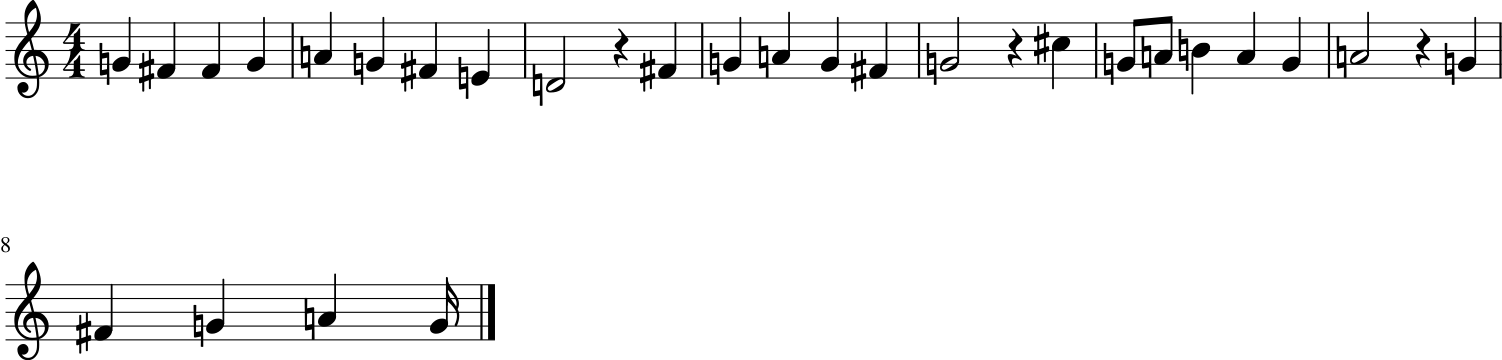

Target example: [ 62 129 129 129  62 129 129 129  62 129 129 129 129 129  61 129  61 129
  66 129 129 129  64 129  62 129 129 129 129 129  61 129  57 129 129 129
 129 129 129 129 128 129 129 129  62 129 129 129  62 129 129 129  63 129
  62 129  62 129 129 129  62 129 129 129  62 129 129 129 129 129 129 129
 128 129 129 129  67 129  66 129  63 129 129 129  62 129  67 129 129 129
  66 129  67 129  55 129  62 129 129 129 129 129 129 129 128 129 129 129
  62 129  61 129  62 129  66 129 129 129  64 129  66 129 129 129  64 129
 129 129]


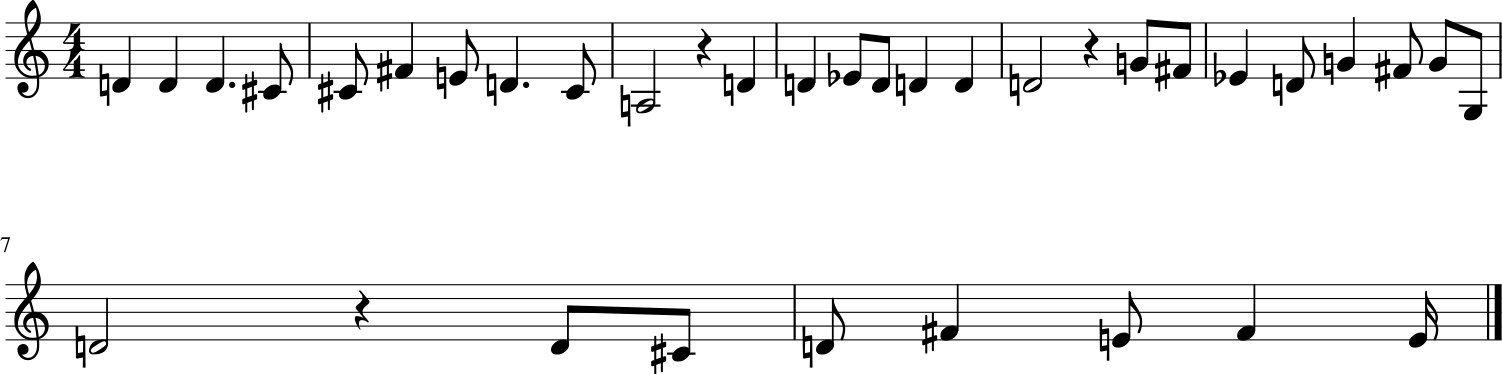

In [17]:
# Load dataset and create pairs of inputs and targets

with np.load('ba.npz') as data:
    train_set = data['train']

# Use even number melody lines as inputs and odd numbers as targets    
raw_inputs = train_set[0:len(train_set):2]
raw_targets = train_set[1:len(train_set):2]

inputs = []
targets = []

for seq in raw_inputs:
    slices = slice_sequence_examples(seq, 128)
    for sl in slices:
        inputs.append(sl)

for seq in raw_targets:
    slices = slice_sequence_examples(seq, 128)
    for sl in slices:
        targets.append(sl)

print("Number of input/target pairs:", len(inputs))
print()

# Print examples of inputs and targets
example_in = inputs[0]
example_target = targets[0]
print("Input example:", example_in)
s = noteArrayToStream(example_in)
s.show()
print("Target example:", example_target)
s = noteArrayToStream(example_target)
s.show()


In [4]:
input_sequences = list(inputs)
target_sequences = []
input_set = set()
target_set = set()
num_samples = len(inputs)
    
for i in range(num_samples):    
    target_with_tokens = [200] + list(targets[i]) + [201] # use 200 as start token and 201 as end token
    target_sequences.append(target_with_tokens)
    
    # Add unique notes to set of notes
    for item in input_sequences[i]:
        if (item not in input_set):
            input_set.add(item)
    
    for item in target_with_tokens:
        if (item not in target_set):
            target_set.add(item)
            
input_set = sorted(list(input_set))
target_set = sorted(list(target_set))
print("Set of input notes:\n", input_set)
print("Set of target notes:\n", target_set)
print(len(input_set))

Set of input notes:
 [51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 128, 129]
Set of target notes:
 [37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 128, 129, 200, 201]
32


In [5]:
# dictionary to index each input note - key is index and value is the note
input_index_to_note_dict = {}

# dictionary to get note given its index - key is the note and value is the index
input_note_to_index_dict = {}

for k, v in enumerate(input_set):
    input_index_to_note_dict[k] = v
    input_note_to_index_dict[v] = k

In [6]:
# dictionary to index each target note - key is index and value is the note
target_index_to_note_dict = {}

# dictionary to get note given its index - key is the note and value is the index
target_note_to_index_dict = {}

for k, v in enumerate(target_set):
    target_index_to_note_dict[k] = v
    target_note_to_index_dict[v] = k

In [7]:
max_len_inputs = max([len(seq) for seq in input_sequences])
max_len_targets = max([len(line) for line in target_sequences])
print(max_len_inputs)
print(max_len_targets)

128
130


In [8]:
tokenized_input_sequences = np.zeros(shape=(num_samples,max_len_inputs,len(input_set)), dtype='float32')
tokenized_target_sequences = np.zeros(shape=(num_samples,max_len_targets,len(target_set)), dtype='float32')
target_data = np.zeros((num_samples, max_len_targets, len(target_set)),dtype='float32')

In [9]:
for i in range(num_samples):
    for k, note_value in enumerate(input_sequences[i]):
        tokenized_input_sequences[i,k,input_note_to_index_dict[note_value]] = 1
    
    for k, note_value in enumerate(target_sequences[i]):
        tokenized_target_sequences[i,k,target_note_to_index_dict[note_value]] = 1
        
        # decoder_target_data will be ahead by one timestep and will not include the start character.
        if k > 0:
            target_data[i,k-1, target_note_to_index_dict[note_value]] = 1

In [10]:
# Encoder model

encoder_input = Input(shape=(None,len(input_set)))
encoder_LSTM = LSTM(256,return_state = True)
encoder_outputs, encoder_h, encoder_c = encoder_LSTM (encoder_input)
encoder_states = [encoder_h, encoder_c]

In [11]:
# Decoder model

decoder_input = Input(shape=(None,len(target_set)))
decoder_LSTM = LSTM(256,return_sequences=True, return_state = True)
decoder_out, _ , _ = decoder_LSTM(decoder_input, initial_state=encoder_states)
decoder_dense = Dense(len(target_set),activation='softmax')
decoder_out = decoder_dense (decoder_out)

In [12]:
"""model = Model(inputs=[encoder_input, decoder_input],outputs=[decoder_out])

# Run training
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.fit(x=[tokenized_input_sequences,tokenized_target_sequences], 
          y=target_data,
          batch_size=32,
          epochs=1,
          validation_split=0.2)
model.save("trained_model.h5")"""

'model = Model(inputs=[encoder_input, decoder_input],outputs=[decoder_out])\n\n# Run training\nmodel.compile(optimizer=\'adam\', loss=\'categorical_crossentropy\')\nmodel.fit(x=[tokenized_input_sequences,tokenized_target_sequences], \n          y=target_data,\n          batch_size=32,\n          epochs=1,\n          validation_split=0.2)\nmodel.save("trained_model.h5")'

In [13]:
#model = load_model("trained_model.h5")

In [14]:
# Inference models for testing

# Encoder inference model
encoder_model_inf = Model(encoder_input, encoder_states)

# Decoder inference model
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_input_states = [decoder_state_input_h, decoder_state_input_c]

decoder_out, decoder_h, decoder_c = decoder_LSTM(decoder_input, 
                                                 initial_state=decoder_input_states)

decoder_states = [decoder_h , decoder_c]

decoder_out = decoder_dense(decoder_out)

decoder_model_inf = Model(inputs=[decoder_input] + decoder_input_states,
                          outputs=[decoder_out] + decoder_states )

In [15]:
def decode_seq(inp_seq):
    
    # Initial states value is coming from the encoder 
    states_val = encoder_model_inf.predict(inp_seq)
   
    target_seq = np.zeros((1, 1, len(target_set)))
    target_seq[0, 0, target_note_to_index_dict[200]] = 1

    decoded_sequence = []
    stop_condition = False
    
    while not stop_condition:       
        decoder_out, decoder_h, decoder_c = decoder_model_inf.predict(x=[target_seq] + states_val)      
        max_val_index = np.argmax(decoder_out[0,-1,:])
        sampled_note = target_index_to_note_dict[max_val_index]
        decoded_sequence.append(sampled_note)
        
        if ((sampled_note == 201) or (len(decoded_sequence) > max_len_targets)):
            stop_condition = True
        
        target_seq = np.zeros((1, 1, len(target_set)))
        target_seq[0, 0, max_val_index] = 1
        
        states_val = [decoder_h, decoder_c]
        
    return np.array(decoded_sequence)

-
Input sentence: [ 67 129 129 129  66 129 129 129  66 129 129 129  67 129 129 129  69 129
 129 129  67 129 129 129  66 129 129 129  64 129 129 129  62 129 129 129
 129 129 129 129 128 129 129 129  66 129 129 129  67 129 129 129  69 129
 129 129  67 129 129 129  66 129 129 129  67 129 129 129 129 129 129 129
 128 129 129 129  73 129 129 129  67 129  69 129  71 129 129 129  69 129
 129 129  67 129 129 129  69 129 129 129 129 129 129 129 128 129 129 129
  67 129 129 129  66 129 129 129  67 129 129 129  69 129 129 129  67 129
 129 129]
Decoded sentence: [ 61  59  66 200  59  63  63  63  66  63  63  66  63  66  63  66 200  56
  66  56  47  47  53  53  48  70  48  48  65  65  71  58  71  41  41  41
  53  53  48  48  65  52  73  58  71  41  41  65  73  65  58  71  41  41
  41  41  52  61  58  52  73  74  69  41  41  53  53  48  41  65  52  73
  58  71  41  41  41  52  61  73  58  69  69  69  69  61  61  58  69  69
  69  69  69  61  59  66 200  59  63  63  63  63  66  63  63  66  63  66
  63 

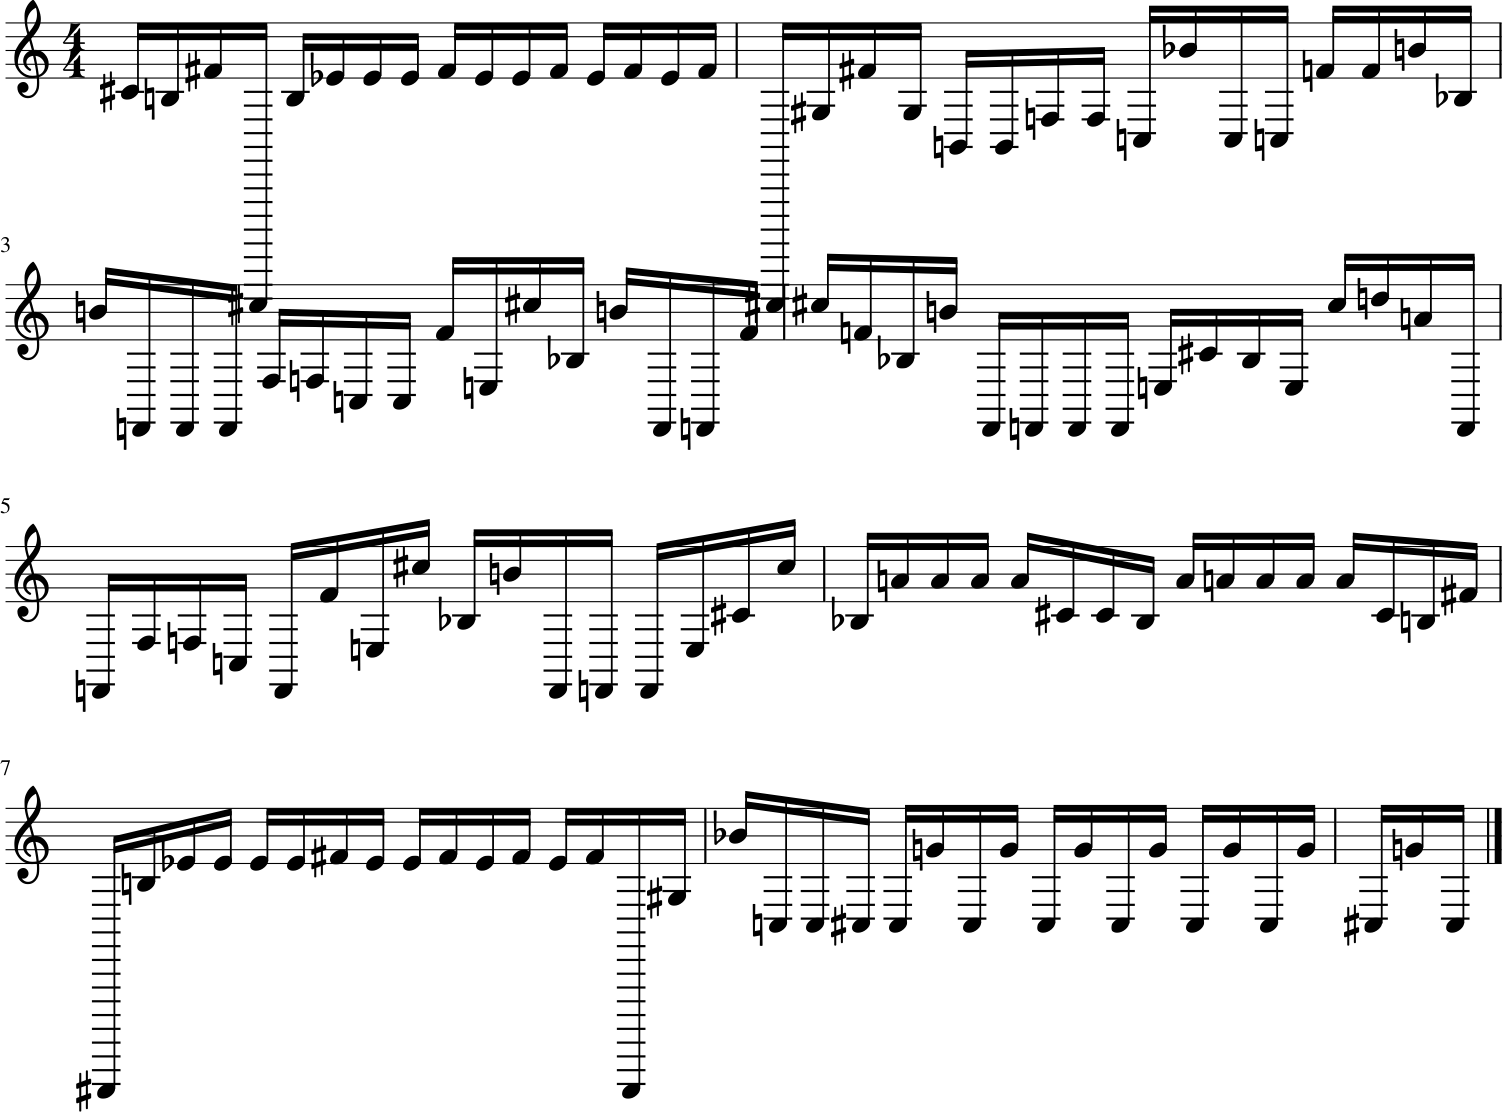

-
Input sentence: [129 129 129  66 129 129 129  66 129 129 129  67 129 129 129  69 129 129
 129  67 129 129 129  66 129 129 129  64 129 129 129  62 129 129 129 129
 129 129 129 128 129 129 129  66 129 129 129  67 129 129 129  69 129 129
 129  67 129 129 129  66 129 129 129  67 129 129 129 129 129 129 129 128
 129 129 129  73 129 129 129  67 129  69 129  71 129 129 129  69 129 129
 129  67 129 129 129  69 129 129 129 129 129 129 129 128 129 129 129  67
 129 129 129  66 129 129 129  67 129 129 129  69 129 129 129  67 129 129
 129  66]
Decoded sentence: [59 57 66 56 66 56 47 42 42 42 42 47 42 42 51 47 42 42 42 51 47 42 42 42
 51 47 42 42 42 51 47 42 42 42 51 47 42 42 42 51 47 42 42 42 51 47 42 42
 42 51 47 42 42 42 51 47 42 42 42 51 47 42 42 42 51 47 42 42 42 51 47 42
 42 42 51 47 42 42 42 51 47 42 42 42 51 47 42 42 42 51 47 42 42 42 51 47
 42 42 42 51 47 42 42 42 51 47 42 42 42 51 47 42 42 42 51 47 42 42 42 51
 47 42 42 42 51 47 42 42 42 51 47]


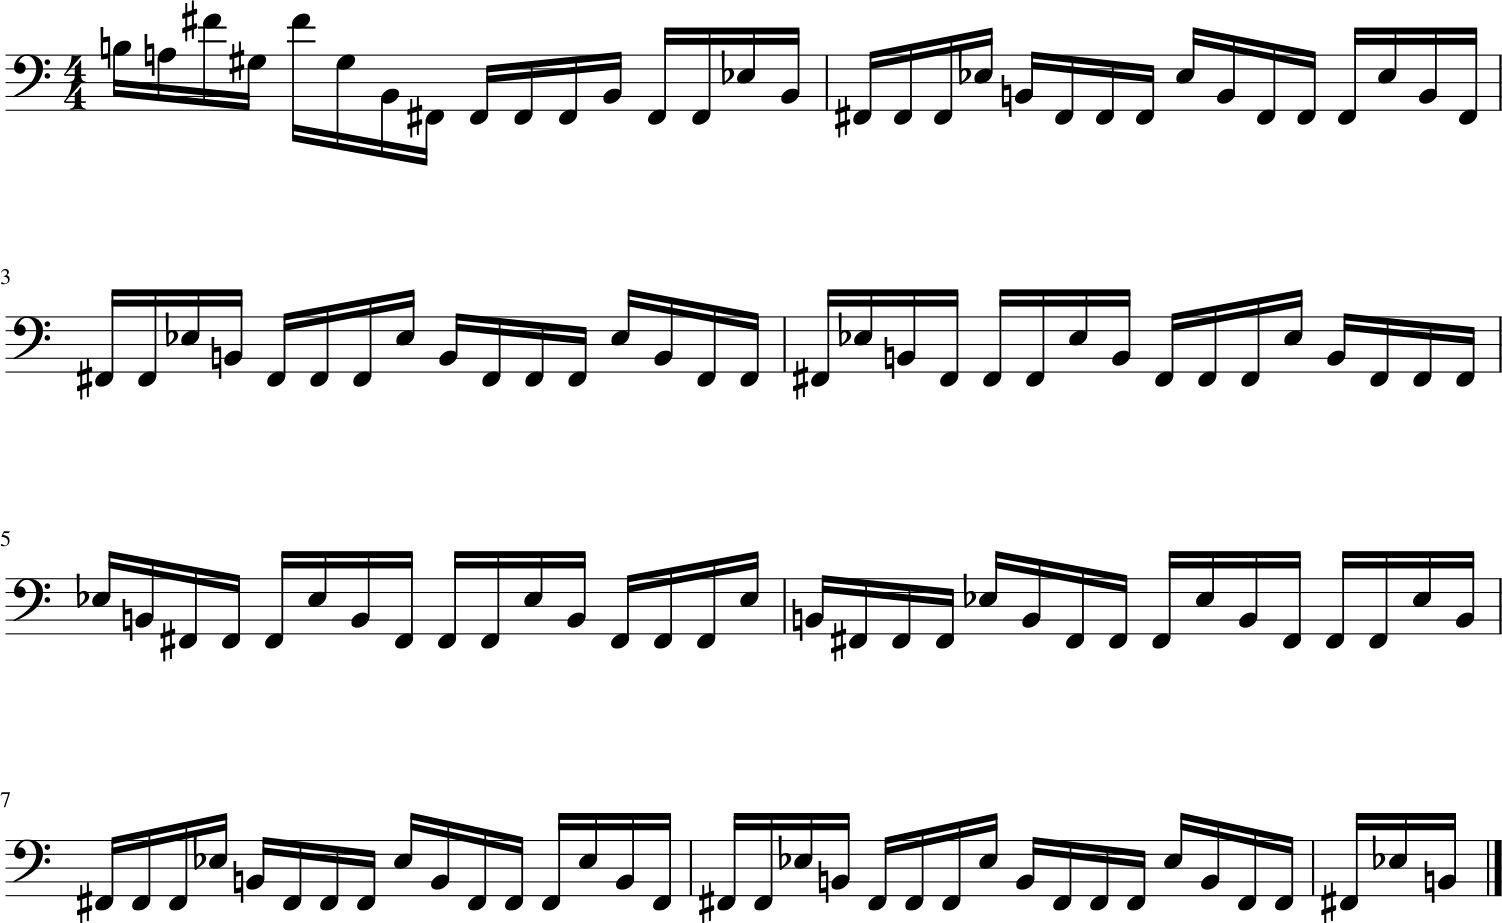

-
Input sentence: [129 129  66 129 129 129  66 129 129 129  67 129 129 129  69 129 129 129
  67 129 129 129  66 129 129 129  64 129 129 129  62 129 129 129 129 129
 129 129 128 129 129 129  66 129 129 129  67 129 129 129  69 129 129 129
  67 129 129 129  66 129 129 129  67 129 129 129 129 129 129 129 128 129
 129 129  73 129 129 129  67 129  69 129  71 129 129 129  69 129 129 129
  67 129 129 129  69 129 129 129 129 129 129 129 128 129 129 129  67 129
 129 129  66 129 129 129  67 129 129 129  69 129 129 129  67 129 129 129
  66 129]
Decoded sentence: [ 61  59  66 200  59  63  63  63  66  63  63  66  63  66  63  66 200  56
  66  56  47  47  53  53  48  70  48  48  65  65  71  58  71  41  41  41
  53  53  48  48  65  52  73  58  71  41  41  65  73  65  58  71  41  41
  41  41  52  61  58  52  73  74  69  41  41  53  53  48  41  65  52  73
  58  71  41  41  41  52  61  73  58  69  69  69  69  61  61  58  69  69
  69  69  69  61  59  66 200  59  63  63  63  63  66  63  63  66  63  66
  63 

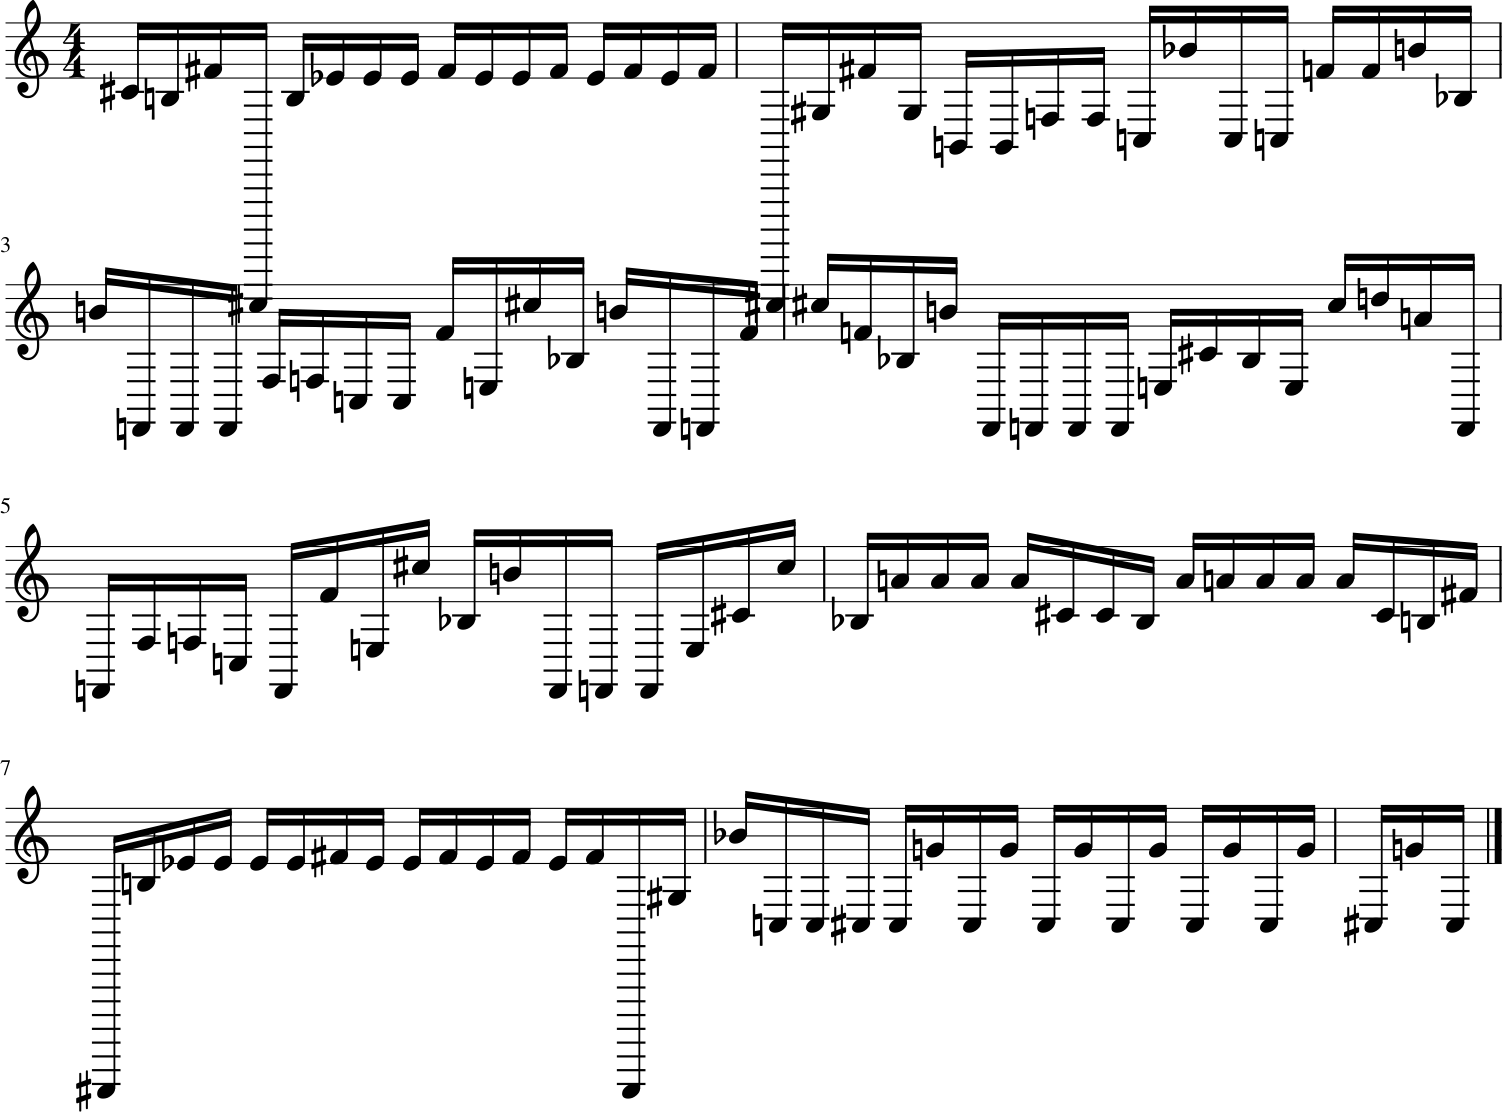

-
Input sentence: [129  66 129 129 129  66 129 129 129  67 129 129 129  69 129 129 129  67
 129 129 129  66 129 129 129  64 129 129 129  62 129 129 129 129 129 129
 129 128 129 129 129  66 129 129 129  67 129 129 129  69 129 129 129  67
 129 129 129  66 129 129 129  67 129 129 129 129 129 129 129 128 129 129
 129  73 129 129 129  67 129  69 129  71 129 129 129  69 129 129 129  67
 129 129 129  69 129 129 129 129 129 129 129 128 129 129 129  67 129 129
 129  66 129 129 129  67 129 129 129  69 129 129 129  67 129 129 129  66
 129 129]
Decoded sentence: [ 61  59  66 200  59  63  63  63  66  63  63  66  63  66  63  66 200  56
  66  56  47  47  53  53  48  70  48  48  65  65  71  58  71  41  41  41
  53  53  48  48  65  52  73  58  71  41  41  65  73  65  58  71  41  41
  41  41  52  61  58  52  73  74  69  41  41  53  53  48  41  65  52  73
  58  71  41  41  41  52  61  73  58  69  69  69  69  61  61  58  69  69
  69  69  69  61  59  66 200  59  63  63  63  63  66  63  63  66  63  66
  63 

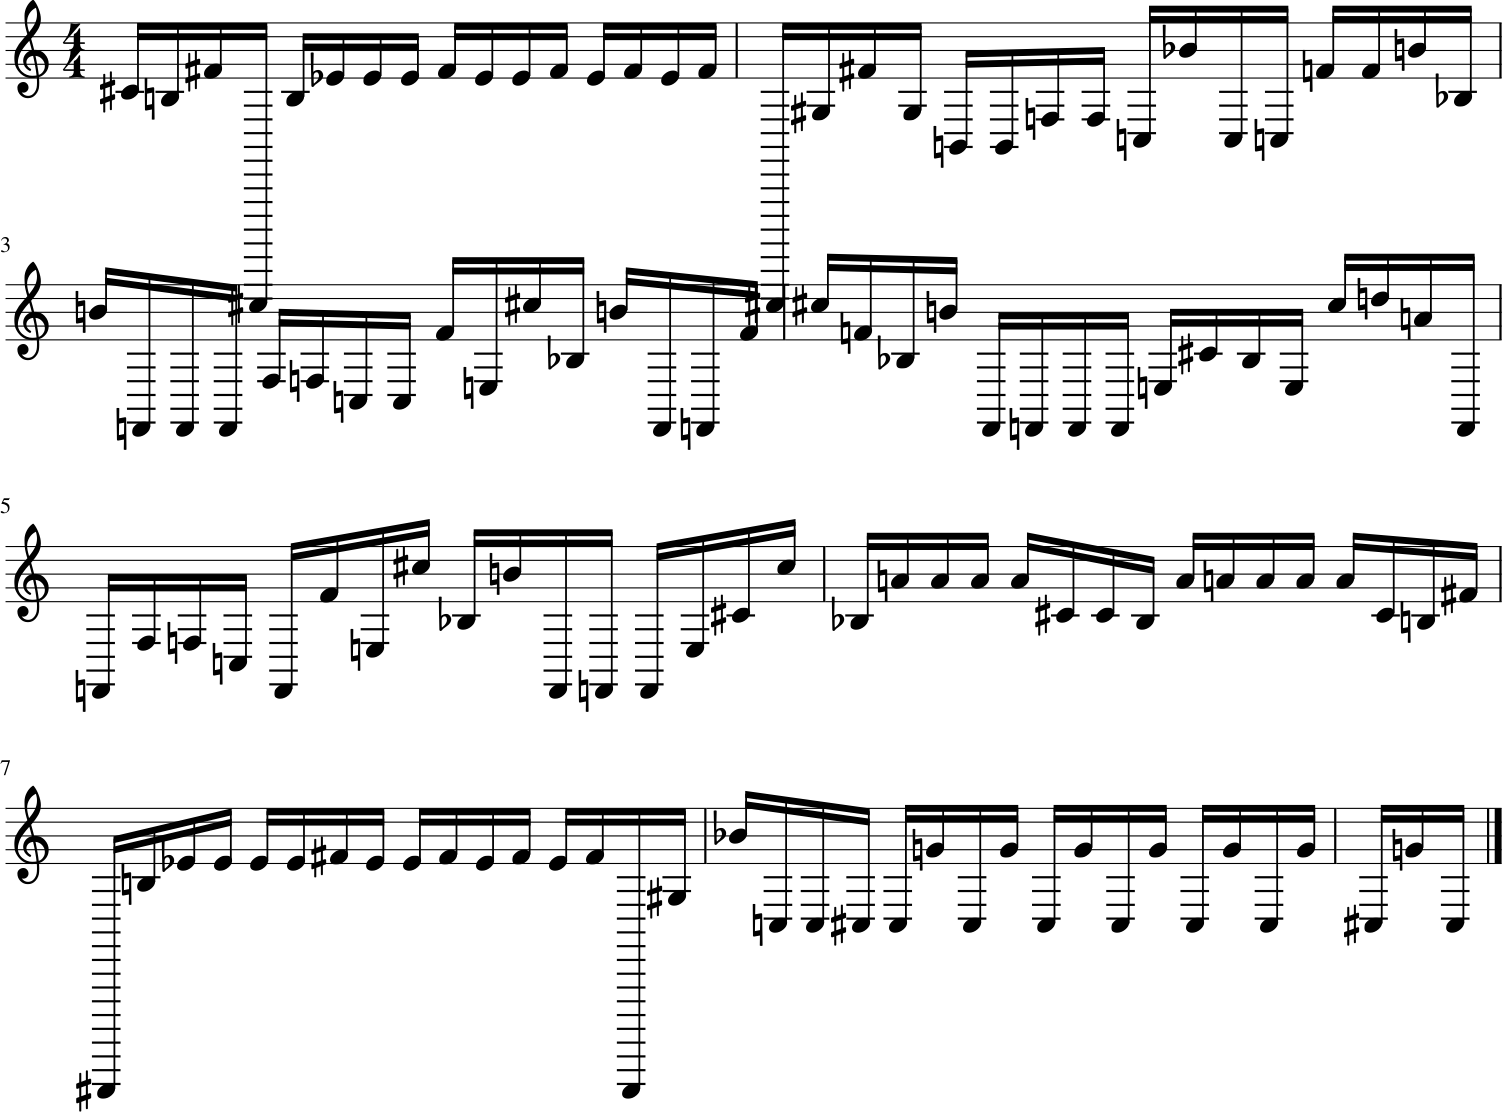

-
Input sentence: [ 66 129 129 129  66 129 129 129  67 129 129 129  69 129 129 129  67 129
 129 129  66 129 129 129  64 129 129 129  62 129 129 129 129 129 129 129
 128 129 129 129  66 129 129 129  67 129 129 129  69 129 129 129  67 129
 129 129  66 129 129 129  67 129 129 129 129 129 129 129 128 129 129 129
  73 129 129 129  67 129  69 129  71 129 129 129  69 129 129 129  67 129
 129 129  69 129 129 129 129 129 129 129 128 129 129 129  67 129 129 129
  66 129 129 129  67 129 129 129  69 129 129 129  67 129 129 129  66 129
 129 129]
Decoded sentence: [ 61  59  66 200  59  63  63  63  66  63  63  66  63  66  63  66 200  56
  66  56  47  47  53  53  48  70  48  48  65  65  71  58  71  41  41  41
  53  53  48  48  65  52  73  58  71  41  41  65  73  65  58  71  41  41
  41  41  52  61  58  52  73  74  69  41  41  53  53  48  41  65  52  73
  58  71  41  41  41  52  61  73  58  69  69  69  69  61  61  58  69  69
  69  69  69  61  59  66 200  59  63  63  63  63  66  63  63  66  63  66
  63 

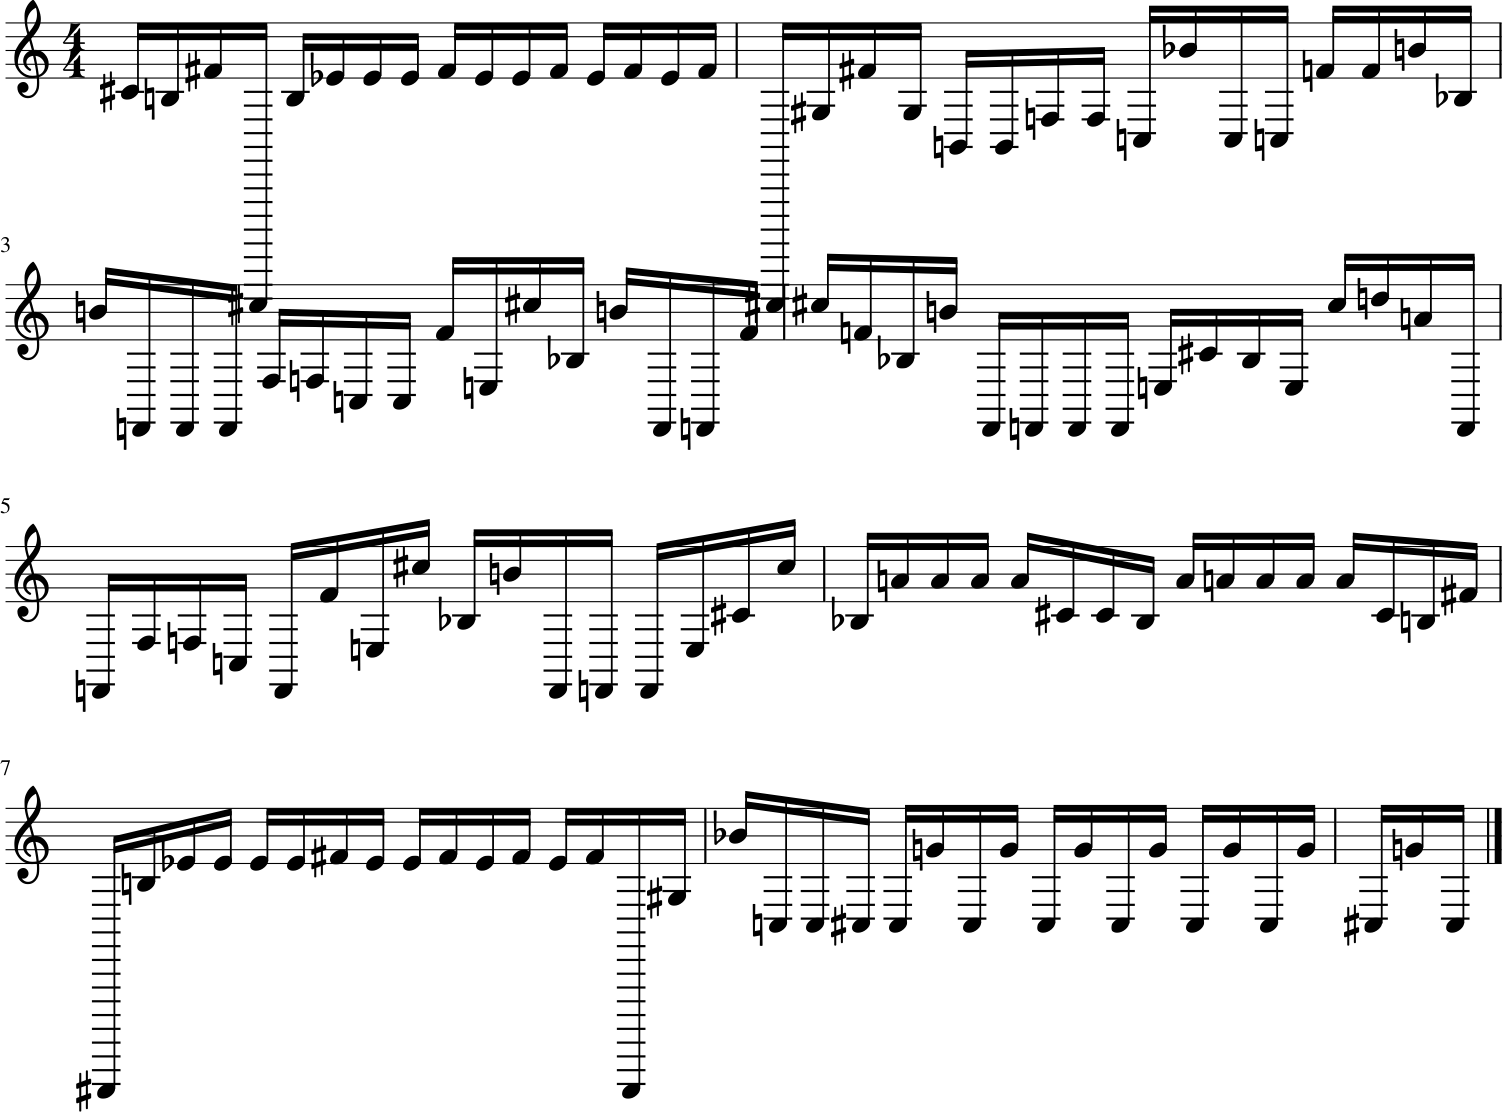

In [16]:
for seq_index in range(5):
    inp_seq = tokenized_input_sequences[seq_index:seq_index+1]
    decoded_sequence = decode_seq(inp_seq)
    print('-')
    print('Input sentence:', input_sequences[seq_index])
    print('Decoded sentence:', decoded_sequence)
    
    input_stream = noteArrayToStream(input_sequences[seq_index])
    decoded_stream = noteArrayToStream(decoded_sequence)
    #input_stream.show()
    #decoded_stream.show()

    

In [119]:
# Read samples from textfile (downloaded from Colab)

#with open('pairs.txt', 'r') as f:
with open('pairs_large_bach.txt', 'r') as f:
    content = f.readlines()   

list_of_strings = [item.split() for item in content]
content_as_list = []
for item in list_of_strings:
    content_as_list.append([int(x) for x in item])

# Even number melody lines as inputs and odd numbers as outputs
input_seq = content_as_list[0:len(content_as_list):2]
output_seq = content_as_list[1:len(content_as_list):2]

#pathname = "/home/torgrim/master/IN5490/generated_pairs/"
pathname = "/home/torgrim/master/IN5490/generated_pairs/large_bach/"

for sample_number in range(len(input_seq)):
    input_stream = noteArrayToStream(input_seq[sample_number])
    decoded_stream = noteArrayToStream(output_seq[sample_number])
    
    input_midi = midi.translate.streamToMidiFile(input_stream)
    input_midi.open(pathname+"input_midi_"+str(sample_number)+".mid", "wb")
    input_midi.write()
    input_midi.close()

    output_midi = midi.translate.streamToMidiFile(decoded_stream)
    output_midi.open(pathname+"output_midi_"+str(sample_number)+".mid", "wb")
    output_midi.write()
    output_midi.close()


In [95]:
from music21 import corpus
chorales = corpus.getComposer('bach', 'xml')
chorale_list = []
for chorale in chorales:
    chorale_list.append(converter.parse(chorale))

In [121]:
# Create inputs of Soprano and Tenor, and outputs of Alto and Bass
inputs = []
targets = []
reference_set = set(["Soprano", "Alto", "Tenor", "Bass"])

for i, chorale in enumerate(chorale_list):
    part_set = set([parts.id for parts in chorale])
    if reference_set.issubset(part_set):
        for part in chorale:
            if part.id == "Soprano" or part.id == "Tenor":
                inputs.append(streamToNoteArray(part))
            elif part.id == "Alto" or part.id == "Bass":
                targets.append(streamToNoteArray(part))              
    else:
        print("Skipped", i)
print(len(inputs))
print(len(targets))

Skipped 65
Skipped 97
Skipped 165
Skipped 322
Skipped 394
810
810


In [ ]:
"""# Use external midi file as input

test_input_midi = converter.parse("input_midi_0.mid")
test_input = streamToNoteArray(test_input_midi)

tokenized_input = np.zeros(shape=(1,len(test_input),len(input_set)), dtype='float32')     
for i in range(1):
    for k, note_value in enumerate(test_input):
        tokenized_input[i,k,input_note_to_index_dict[note_value]] = 1


decoded_sequence = decode_seq(tokenized_input)
decoded_stream = noteArrayToStream(decoded_sequence)
decoded_stream.show()

midi_file = midi.translate.streamToMidiFile(decoded_stream)
midi_file.open("output_test_0.mid", "wb")
midi_file.write()
midi_file.close()"""

In [ ]:
"""# External input from textfile

custom_sequence = converter.parse("custom_input.mid")
custom_sequence = streamToNoteArray(custom_sequence)

with open('custom.txt', 'w') as f: 
    input_string = " ".join(map(str,custom_sequence))
    f.write("%s\n" % input_string)
    
with open('custom.txt', 'r') as f:
    content = f.readlines()   

to_list = content[0].split()
as_list = np.array([int(x) for x in to_list])
print(as_list)

input_stream = noteArrayToStream(as_list)
input_stream.show()"""

In [ ]:
"""# Create midi files from custom input
with open('custom_pair.txt', 'r') as f:
    content = f.readlines()   

list_of_strings = [item.split() for item in content]
content_as_list = []
for item in list_of_strings:
    content_as_list.append([int(x) for x in item])

# Even number melody lines as inputs and odd numbers as outputs
input_seq = content_as_list[0:len(content_as_list):2]
output_seq = content_as_list[1:len(content_as_list):2]

pathname = "/home/torgrim/master/IN5490/generated_pairs/"

for sample_number in range(len(input_seq)):
    input_stream = noteArrayToStream(input_seq[sample_number])
    decoded_stream = noteArrayToStream(output_seq[sample_number])
    
    input_midi = midi.translate.streamToMidiFile(input_stream)
    input_midi.open(pathname+"custom_input_midi_"+str(sample_number)+".mid", "wb")
    input_midi.write()
    input_midi.close()

    output_midi = midi.translate.streamToMidiFile(decoded_stream)
    output_midi.open(pathname+"custom_output_midi_"+str(sample_number)+".mid", "wb")
    output_midi.write()
    output_midi.close()"""

In [120]:
#chorale_list[1].show()

In [50]:
for part in chorale_list[1].parts:
    print(part.id)
    #part.show()

Soprano
Alto
Tenor
Bass


In [116]:
# Create one training array
# Order:
# Soprano
# Alto
# Tenor
# Bass

training_array = []
reference_set = set(["Soprano", "Alto", "Tenor", "Bass"])

for i, chorale in enumerate(chorale_list):
    part_set = set([parts.id for parts in chorale])
    if reference_set.issubset(part_set):
        for part in chorale:
            if part.id in reference_set:
                training_array.append(part) 
    else:
        print("Skipped", i)

appended 0
appended 0
appended 0
appended 0
appended 1
appended 1
appended 1
appended 1
appended 2
appended 2
appended 2
appended 2
appended 3
appended 3
appended 3
appended 3
appended 4
appended 4
appended 4
appended 4
appended 5
appended 5
appended 5
appended 5
appended 6
appended 6
appended 6
appended 6
appended 7
appended 7
appended 7
appended 7
appended 8
appended 8
appended 8
appended 8
appended 9
appended 9
appended 9
appended 9
appended 10
appended 10
appended 10
appended 10
appended 11
appended 11
appended 11
appended 11
appended 12
appended 12
appended 12
appended 12
appended 13
appended 13
appended 13
appended 13
appended 14
appended 14
appended 14
appended 14
appended 15
appended 15
appended 15
appended 15
appended 16
appended 16
appended 16
appended 16
appended 17
appended 17
appended 17
appended 17
appended 18
appended 18
appended 18
appended 18
appended 19
appended 19
appended 19
appended 19
appended 20
appended 20
appended 20
appended 20
appended 21
appended 21
appended

appended 226
appended 226
appended 226
appended 227
appended 227
appended 227
appended 227
appended 228
appended 228
appended 228
appended 228
appended 229
appended 229
appended 229
appended 229
appended 230
appended 230
appended 230
appended 230
appended 231
appended 231
appended 231
appended 231
appended 232
appended 232
appended 232
appended 232
appended 233
appended 233
appended 233
appended 233
appended 234
appended 234
appended 234
appended 234
appended 235
appended 235
appended 235
appended 235
appended 236
appended 236
appended 236
appended 236
appended 237
appended 237
appended 237
appended 237
appended 238
appended 238
appended 238
appended 238
appended 239
appended 239
appended 239
appended 239
appended 240
appended 240
appended 240
appended 240
appended 241
appended 241
appended 241
appended 241
appended 242
appended 242
appended 242
appended 242
appended 243
appended 243
appended 243
appended 243
appended 244
appended 244
appended 244
appended 244
appended 245
appended 245

skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skipped 144
skip

In [104]:
"""for chorale in chorale_list[0:5]:
    for part in chorale:
        print(part)"""

<music21.text.TextBox "BWV 1.6  W...">
<music21.text.TextBox "Harmonized...">
<music21.text.TextBox "PDF ©2004 ...">
<music21.stream.Part Horn 2>
<music21.stream.Part Soprano>
<music21.stream.Part Alto>
<music21.stream.Part Tenor>
<music21.stream.Part Bass>
<music21.layout.ScoreLayout>
<music21.layout.StaffGroup <music21.stream.Part Soprano><music21.stream.Part Alto><music21.stream.Part Tenor><music21.stream.Part Bass>>
<music21.text.TextBox "PDF © 2004...">
<music21.text.TextBox "BWV 10.7">
<music21.stream.Part Soprano>
<music21.stream.Part Alto>
<music21.stream.Part Tenor>
<music21.stream.Part Bass>
<music21.layout.ScoreLayout>
<music21.layout.StaffGroup <music21.stream.Part Soprano><music21.stream.Part Alto><music21.stream.Part Tenor><music21.stream.Part Bass>>
<music21.text.TextBox "PDF © 2004...">
<music21.text.TextBox "BWV 101.7">
<music21.stream.Part Soprano>
<music21.stream.Part Alto>
<music21.stream.Part Tenor>
<music21.stream.Part Bass>
<music21.layout.ScoreLayout>
<music21.l

In [115]:
"""chorales = corpus.getComposer('bach', 'xml')
chorale_list = []
for chorale in chorales:
    chorale_list.append(converter.parse(chorale))
"""


appended 0
appended 0
appended 0
appended 0
Skipped 0
appended 1
appended 1
appended 1
appended 1
Skipped 1
appended 2
appended 2
appended 2
appended 2
Skipped 2
appended 3
appended 3
appended 3
appended 3
Skipped 3
appended 4
appended 4
appended 4
appended 4
Skipped 4
appended 5
appended 5
appended 5
appended 5
Skipped 5
appended 6
appended 6
appended 6
appended 6
Skipped 6
appended 7
appended 7
appended 7
appended 7
Skipped 7
appended 8
appended 8
appended 8
appended 8
Skipped 8
appended 9
appended 9
appended 9
appended 9
Skipped 9
appended 10
appended 10
appended 10
appended 10
Skipped 10
appended 11
appended 11
appended 11
appended 11
Skipped 11
appended 12
appended 12
appended 12
appended 12
Skipped 12
appended 13
appended 13
appended 13
appended 13
Skipped 13
appended 14
appended 14
appended 14
appended 14
Skipped 14
appended 15
appended 15
appended 15
appended 15
Skipped 15
appended 16
appended 16
appended 16
appended 16
Skipped 16
appended 17
appended 17
appended 17
appended 17

Skipped 197
appended 198
appended 198
appended 198
appended 198
Skipped 198
appended 199
appended 199
appended 199
appended 199
Skipped 199
appended 200
appended 200
appended 200
appended 200
Skipped 200
appended 201
appended 201
appended 201
appended 201
Skipped 201
appended 202
appended 202
appended 202
appended 202
Skipped 202
appended 203
appended 203
appended 203
appended 203
Skipped 203
appended 204
appended 204
appended 204
appended 204
Skipped 204
appended 205
appended 205
appended 205
appended 205
Skipped 205
appended 206
appended 206
appended 206
appended 206
Skipped 206
appended 207
appended 207
appended 207
appended 207
Skipped 207
appended 208
appended 208
appended 208
appended 208
Skipped 208
appended 209
appended 209
appended 209
appended 209
Skipped 209
appended 210
appended 210
appended 210
appended 210
Skipped 210
appended 211
appended 211
appended 211
appended 211
Skipped 211
appended 212
appended 212
appended 212
appended 212
Skipped 212
appended 213
appended 213
ap

Skipped 338
appended 339
appended 339
appended 339
appended 339
Skipped 339
appended 340
appended 340
appended 340
appended 340
Skipped 340
appended 341
appended 341
appended 341
appended 341
Skipped 341
appended 342
appended 342
appended 342
appended 342
Skipped 342
appended 343
appended 343
appended 343
appended 343
Skipped 343
appended 344
appended 344
appended 344
appended 344
Skipped 344
appended 345
appended 345
appended 345
appended 345
Skipped 345
appended 346
appended 346
appended 346
appended 346
Skipped 346
appended 347
appended 347
appended 347
appended 347
Skipped 347
appended 348
appended 348
appended 348
appended 348
Skipped 348
appended 349
appended 349
appended 349
appended 349
Skipped 349
appended 350
appended 350
appended 350
appended 350
Skipped 350
appended 351
appended 351
appended 351
appended 351
Skipped 351
appended 352
appended 352
appended 352
appended 352
Skipped 352
appended 353
appended 353
appended 353
appended 353
Skipped 353
appended 354
appended 354
ap

['', '', '', '', '']